In [1]:
import os, torch, cv2, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt 
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2;
from PIL import Image
from torchvision import transforms as tfs
import torchvision.transforms as T
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.cuda
from PIL import Image
from torchvision.models.segmentation import fcn_resnet50
from torchvision.transforms import functional as TF
from torchmetrics import JaccardIndex
from torchvision.utils import make_grid
import random

In [2]:
!pip install -U segmentation-models-pytorch albumentations --user
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 77.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=a2355e39b8ef74f21f84b29bdb118c62f26dfe96d2f0e3aad5b0e6bf7abedb55
  Stored in 

In [3]:
from monai.losses import DiceCELoss
import segmentation_models_pytorch as smp

2024-05-21 15:16:05.468896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 15:16:05.469042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 15:16:05.591500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
torch.cuda.is_available()

True

<h1>Подготовка датасета и даталоадера</h1>

In [5]:
class CustomSegmentationDataset(Dataset):
    
    def __init__(self, root, transformations = None):

        im_nii_paths = sorted(glob(f"{root}/Task03_Liver_rs/imagesTr/*.nii"))
        gt_nii_paths = sorted(glob(f"{root}/Task03_Liver_rs/labelsTr/*.nii"))
        
        self.ims, self.gts = self.get_slices(im_nii_paths, gt_nii_paths)
        self.transformations = transformations
        self.n_cls = 3
        
        assert len(self.ims) == len(self.gts)
        
    def __len__(self): return len(self.ims)

    def __getitem__(self, idx):
        
        im, gt = self.ims[idx], self.gts[idx]
        if self.transformations: im, gt = self.apply_transformations(im, gt)
        
        # For visualization purposes
        im = self.preprocess_im(im)
        # For the cases when label equals to 2; to avoid CE Loss error
        #gt[gt > 1] = 1 
        
        return im.float(), gt.unsqueeze(0).long()
        
    def preprocess_im(self, im): 
        
        max_val = torch.max(im)
        im[im < 0] = 0
        
        return im / max_val
    
    def get_slices(self, im_nii_paths, gt_nii_paths): 
        
        ims, gts = [], []
        
        for index, (im_nii, gt_nii) in enumerate(zip(im_nii_paths, gt_nii_paths)):
            if index == 50: break
            print(f"nifti file number {index + 1} is being converted...")
            nii_im_data, nii_gt_data  = self.read_nii(im_nii, gt_nii)
            
            for idx, (im, gt) in enumerate(zip(nii_im_data, nii_gt_data)):
                if len(np.unique(gt)) > 1: ims.append(im); gts.append(gt)
        
        return ims, gts

    def read_nii(self, im, gt): return nib.load(im).get_fdata().transpose(2, 1, 0), nib.load(gt).get_fdata().transpose(2, 1, 0)
    
    def apply_transformations(self, im, gt): 
        transformed = self.transformations(image = im, mask = gt); 
        return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):
        
    assert sum(split) == 1., "Sum of the split must be exactly 1"
    
    ds = CustomSegmentationDataset(root = root, transformations = transformations)
    n_cls = ds.n_cls
    
    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)
    
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
        
    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")
    
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns)
    test_dl = DataLoader(dataset = test_ds, batch_size = bs, shuffle = False, num_workers = ns)
    
    return tr_dl, val_dl, test_dl, n_cls, ds

In [6]:
root = "/kaggle/input/3d-liver-segmentation"
im_h, im_w = 256, 256

trans = A.Compose( 
    [
        A.Resize(im_h, im_w), 
        ToTensorV2(transpose_mask = True), 
    ])

tr_dl, val_dl, test_dl, n_cls, ds = get_dls(root = root, transformations = trans, bs = 16)

nifti file number 1 is being converted...
nifti file number 2 is being converted...
nifti file number 3 is being converted...
nifti file number 4 is being converted...
nifti file number 5 is being converted...
nifti file number 6 is being converted...
nifti file number 7 is being converted...
nifti file number 8 is being converted...
nifti file number 9 is being converted...
nifti file number 10 is being converted...
nifti file number 11 is being converted...
nifti file number 12 is being converted...
nifti file number 13 is being converted...
nifti file number 14 is being converted...
nifti file number 15 is being converted...
nifti file number 16 is being converted...
nifti file number 17 is being converted...
nifti file number 18 is being converted...
nifti file number 19 is being converted...
nifti file number 20 is being converted...
nifti file number 21 is being converted...
nifti file number 22 is being converted...
nifti file number 23 is being converted...
nifti file number 24

In [7]:
for img, label in tr_dl:
    print(img.shape)
    print(label.shape)
    print()
    print("Классы метки: ", np.unique(label))
    break

torch.Size([16, 1, 256, 256])
torch.Size([16, 1, 256, 256])

Классы метки:  [0 1 2]


<h1>Отображение датасета</h1>

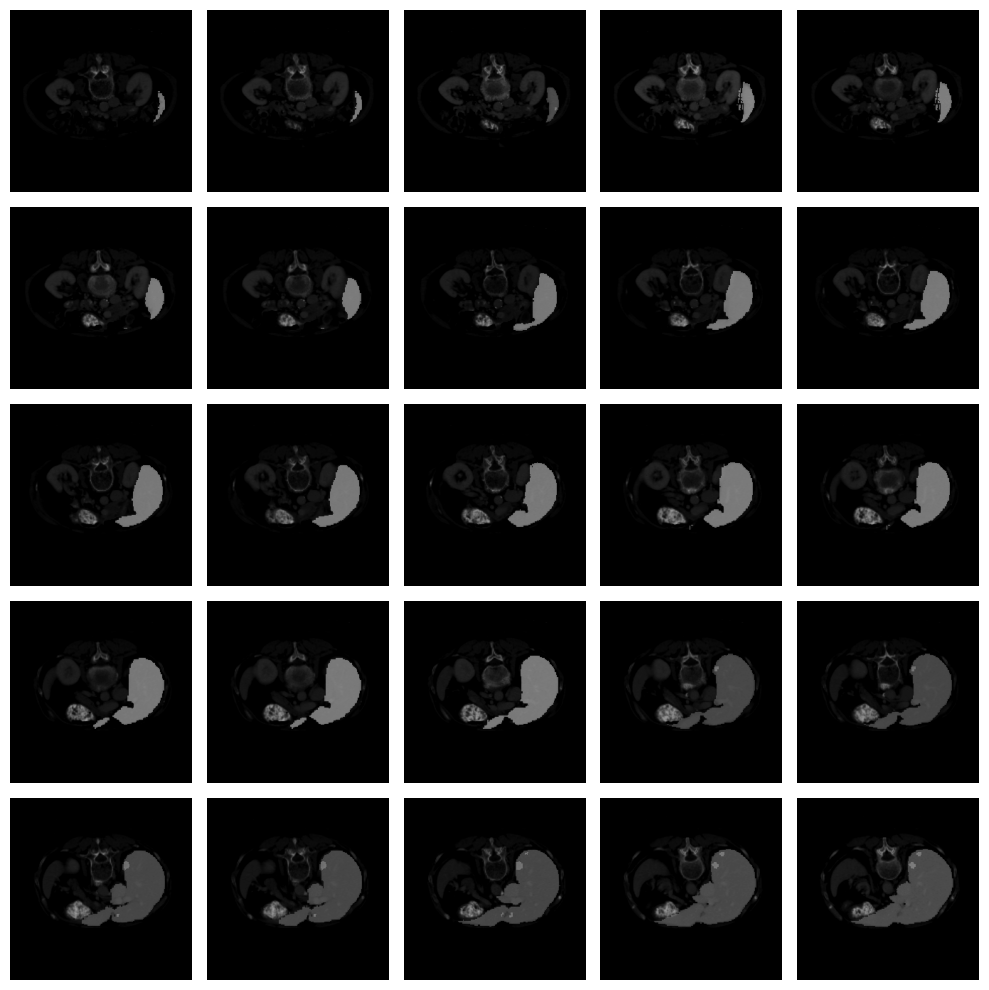

In [8]:
rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    ax.imshow(ds[i][0].squeeze(), cmap='gray')  # Отображение изображения
    ax.imshow(ds[i][1].squeeze(), alpha=0.4, cmap='gray')  # Отображение маски
    ax.axis('off')
    
plt.tight_layout()
plt.show()

<h1>Определение на чем будут обрабатываться данные</h1>

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


<h1>Функция визуазлизации результатов сегментирования на заданной модели</h1>

In [10]:
@torch.inference_mode()
def ans_show(model, batch, num=10, convert_pred=None):
    model.eval()

    as_img = T.ToPILImage()
    
    i = 0
    for x, y in zip(batch[0], batch[1]):
        if i >= num:
            break
            
        img_x = x.unsqueeze(0)
        img_y = y
        
        if convert_pred is None:
            pred = model(img_x.cuda())
            pred = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1,2,0)
        else:
            pred = convert_pred(model, img_x)
        
        img_np = img_x.detach().cpu().numpy()[0].transpose(1,2,0)
        
        fig, ax = plt.subplots(1, 3, figsize=(15, 8))
        ax[0].imshow(img_np, cmap='gray')
        ax[1].imshow(as_img(y.to(torch.uint8)), cmap='gray')
        ax[2].imshow(pred, cmap='gray')

        plt.show()
        i += 1

<h1>Функция расчета индекса Жакара</h1>

In [11]:
@torch.inference_mode()
def get_avg_jaccard(model, data_loader: DataLoader, convert_pred=None):
    jaccard = JaccardIndex(task='binary', num_classes=2).to(device)

    model.eval()
    total_jaccard_index = 0
    threshold = 0.5

    with torch.no_grad():
        for sample in tr_dl:
            img, true_mask = sample
            img = img.float().to(device)

            true_mask = true_mask.to(device)
            true_mask[true_mask > 1] = 1
            true_mask = true_mask.long()
            if convert_pred is None:
                pred_mask = model(img)
                #pred_mask = torch.mean(pred_mask, dim=1, keepdim=True)
                pred_mask = torch.argmax(pred_mask, dim=1)

                pred_mask = pred_mask.squeeze(1)
                
                pred_mask_binary = (torch.sigmoid(pred_mask) > threshold).float()
            else:
                pred_mask_binary = convert_pred(model, img).to(device)
            
            if pred_mask_binary.shape != true_mask.shape: 
                total_jaccard_index += jaccard(pred_mask_binary.unsqueeze(1), true_mask).item()
            else:
                total_jaccard_index += jaccard(pred_mask_binary, true_mask).item()
            


    return total_jaccard_index / len(tr_dl)

<h1>Функция расчета индекса Дайса</h1>

In [12]:
from monai.metrics import DiceMetric

@torch.inference_mode()
def get_avg_dice(model, data_loader: DataLoader, threshold=0.5, convert_pred=None):
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    model.eval()

    dice_metric.reset()

    for img, true_mask in data_loader:
        img = img.to(device).float()
        true_mask = true_mask.to(device)
        true_mask[true_mask > 1] = 1
        
        pred_mask = model(img)

        if convert_pred is not None:
            pred_mask_binary = convert_pred(model, img).to(device)
        else:
            pred_mask = torch.argmax(pred_mask, dim=1)
            pred_mask = torch.sigmoid(pred_mask)
            pred_mask_binary = (pred_mask > threshold).float()
            pred_mask_binary = pred_mask_binary[:, None, ...]

        dice_metric(pred_mask_binary, true_mask[:, None, ...])

    average_dice = dice_metric.aggregate().item()
    dice_metric.reset()

    return average_dice

<h1>Функция точности</h1>

In [13]:
#def pixel_accuracy(output, mask):
#    with torch.no_grad():
#        preds = torch.argmax(output, dim=1)
#        valid = (mask >= 0)
#        acc = (preds == mask).float()[valid].mean()
#    return acc

<h1>Функции для создания чекпоинтов и их выгрузки</h1>

In [14]:
def checkpoint(model, epoch, model_name, checkpoint_dir="./checkpoints"):
    full_checkpoint_dir = os.path.join(checkpoint_dir, model_name)
    os.makedirs(full_checkpoint_dir, exist_ok=True)
    filename = f"{full_checkpoint_dir}/epoch_{epoch}.pth"
    
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

<h1>Функция тренировки модели</h1>

In [15]:
import time


def calculate_loss(pred, gt, loss_fn):
    return loss_fn(pred, gt.squeeze(1).long())


def train(model, loss_fn, scheduler, opt, device, epochs, model_name, threshold=0.005):
    model.to(device)
    
    train_start = time.time()
    print("Start training process...")

    for epoch in range (epochs):
        tic = time.time()
        loss_val = 0

        model.train()
        print(f"Epoch {epoch + 1} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device).float()
            gts = gts.unsqueeze(1)
            preds = model(ims)

            loss = calculate_loss(preds, gts, loss_fn).requires_grad_()
            loss_val += loss.item()


            opt.zero_grad()
            loss.backward()
            opt.step()

            
        scheduler.step()
        print(f'Epoch: {epoch + 1}\t loss: {loss_val/len(tr_dl)}\t lr: {scheduler.get_last_lr()}')  
        checkpoint(model, epoch, model_name)
    print(f"Train process is completed in {(time.time() - train_start) / 60:.3f} minutes")

<h1>DeepLabV3Plus</h1>

In [16]:
model_DeepLabV3Plus = smp.DeepLabV3Plus(classes = 3, in_channels = 1)
loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(params = model_DeepLabV3Plus.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train(model_DeepLabV3Plus, loss_fn, scheduler, optimizer, device, 50, "deeplab")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 224MB/s]


Start training process...
Epoch 1 train process is started...


100%|██████████| 152/152 [00:31<00:00,  4.90it/s]


Epoch: 1	 loss: 0.6124305783918029	 lr: [0.00027]
Epoch 2 train process is started...


100%|██████████| 152/152 [00:30<00:00,  4.95it/s]


Epoch: 2	 loss: 0.36999836740525144	 lr: [0.000243]
Epoch 3 train process is started...


100%|██████████| 152/152 [00:31<00:00,  4.79it/s]


Epoch: 3	 loss: 0.3334423834948163	 lr: [0.0002187]
Epoch 4 train process is started...


100%|██████████| 152/152 [00:33<00:00,  4.60it/s]


Epoch: 4	 loss: 0.3144609576189204	 lr: [0.00019683]
Epoch 5 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 5	 loss: 0.3043899208699402	 lr: [0.000177147]
Epoch 6 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.70it/s]


Epoch: 6	 loss: 0.29801999885392816	 lr: [0.0001594323]
Epoch 7 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.65it/s]


Epoch: 7	 loss: 0.29115217012402256	 lr: [0.00014348907]
Epoch 8 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 8	 loss: 0.2884779022516389	 lr: [0.000129140163]
Epoch 9 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 9	 loss: 0.28467424400150776	 lr: [0.0001162261467]
Epoch 10 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 10	 loss: 0.28104822857207373	 lr: [0.00010460353203]
Epoch 11 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 11	 loss: 0.2786895079832328	 lr: [9.4143178827e-05]
Epoch 12 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 12	 loss: 0.2769678538959277	 lr: [8.47288609443e-05]
Epoch 13 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 13	 loss: 0.27558502554893494	 lr: [7.625597484987e-05]
Epoch 14 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 14	 loss: 0.2742194833331986	 lr: [6.8630377364883e-05]
Epoch 15 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 15	 loss: 0.27290340434563787	 lr: [6.176733962839471e-05]
Epoch 16 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 16	 loss: 0.2705519015067502	 lr: [5.559060566555524e-05]
Epoch 17 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 17	 loss: 0.26894917770435933	 lr: [5.003154509899972e-05]
Epoch 18 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 18	 loss: 0.26870486365729257	 lr: [4.502839058909975e-05]
Epoch 19 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 19	 loss: 0.26728595087402746	 lr: [4.052555153018977e-05]
Epoch 20 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 20	 loss: 0.2668945975601673	 lr: [3.64729963771708e-05]
Epoch 21 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 21	 loss: 0.2651648594948806	 lr: [3.282569673945372e-05]
Epoch 22 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 22	 loss: 0.26513429388011756	 lr: [2.9543127065508348e-05]
Epoch 23 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 23	 loss: 0.2632197305364044	 lr: [2.6588814358957513e-05]
Epoch 24 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 24	 loss: 0.2631756429021296	 lr: [2.392993292306176e-05]
Epoch 25 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 25	 loss: 0.2631782289398344	 lr: [2.1536939630755587e-05]
Epoch 26 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 26	 loss: 0.2618647968690646	 lr: [1.938324566768003e-05]
Epoch 27 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 27	 loss: 0.2625888707606416	 lr: [1.7444921100912026e-05]
Epoch 28 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 28	 loss: 0.26216059403592035	 lr: [1.5700428990820825e-05]
Epoch 29 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 29	 loss: 0.26142450059322936	 lr: [1.4130386091738743e-05]
Epoch 30 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 30	 loss: 0.26127840617769643	 lr: [1.271734748256487e-05]
Epoch 31 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 31	 loss: 0.26061334186478663	 lr: [1.1445612734308383e-05]
Epoch 32 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 32	 loss: 0.2607268486171961	 lr: [1.0301051460877545e-05]
Epoch 33 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 33	 loss: 0.2597507486413968	 lr: [9.27094631478979e-06]
Epoch 34 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 34	 loss: 0.2595137841999531	 lr: [8.343851683310812e-06]
Epoch 35 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 35	 loss: 0.2598332696055111	 lr: [7.509466514979731e-06]
Epoch 36 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 36	 loss: 0.2590077854692936	 lr: [6.758519863481758e-06]
Epoch 37 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.66it/s]


Epoch: 37	 loss: 0.2587870684893508	 lr: [6.082667877133583e-06]
Epoch 38 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.66it/s]


Epoch: 38	 loss: 0.2587871386816627	 lr: [5.4744010894202246e-06]
Epoch 39 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 39	 loss: 0.25875795524763434	 lr: [4.9269609804782025e-06]
Epoch 40 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 40	 loss: 0.2584144365238516	 lr: [4.434264882430382e-06]
Epoch 41 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 41	 loss: 0.2584433536976576	 lr: [3.990838394187344e-06]
Epoch 42 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 42	 loss: 0.2582454568657436	 lr: [3.59175455476861e-06]
Epoch 43 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 43	 loss: 0.2587855683737679	 lr: [3.2325790992917493e-06]
Epoch 44 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 44	 loss: 0.2580745901520315	 lr: [2.9093211893625745e-06]
Epoch 45 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 45	 loss: 0.2576555876355422	 lr: [2.618389070426317e-06]
Epoch 46 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 46	 loss: 0.2588938315840144	 lr: [2.3565501633836854e-06]
Epoch 47 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 47	 loss: 0.2573193829310568	 lr: [2.120895147045317e-06]
Epoch 48 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


Epoch: 48	 loss: 0.25828371216592033	 lr: [1.9088056323407854e-06]
Epoch 49 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 49	 loss: 0.25767854571734605	 lr: [1.717925069106707e-06]
Epoch 50 train process is started...


100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


Epoch: 50	 loss: 0.2576510843477751	 lr: [1.5461325621960363e-06]
Train process is completed in 27.169 minutes


In [17]:
@torch.inference_mode()
def get_DeepLabV3Plus_pred(model, img):
    model.eval()
    return torch.argmax(model_DeepLabV3Plus(img.to(device)), dim=1).cpu().squeeze(0)

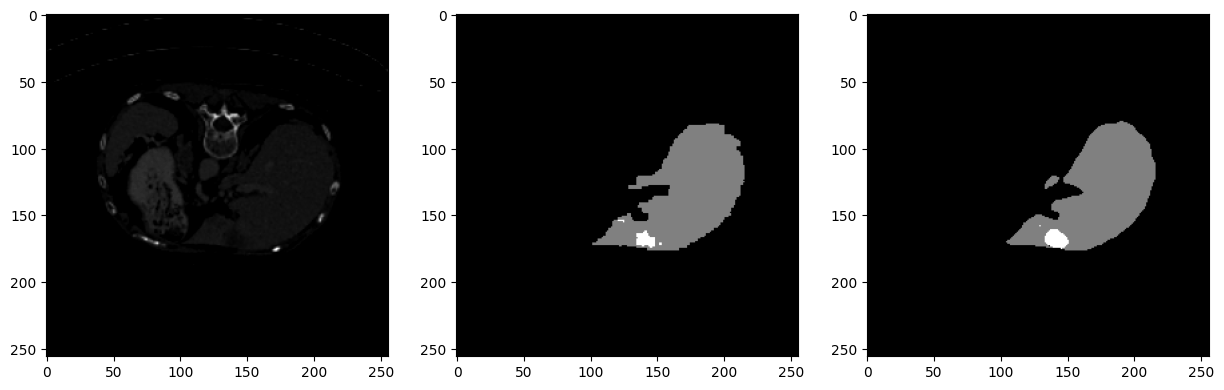

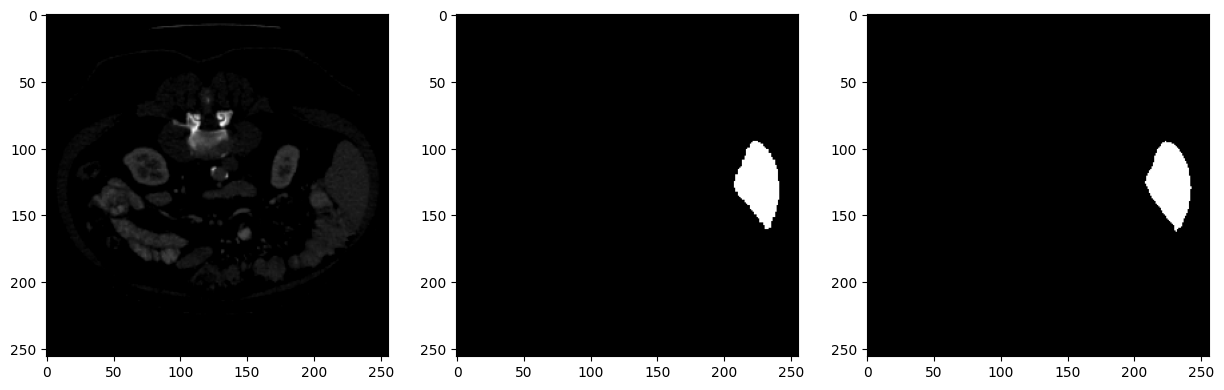

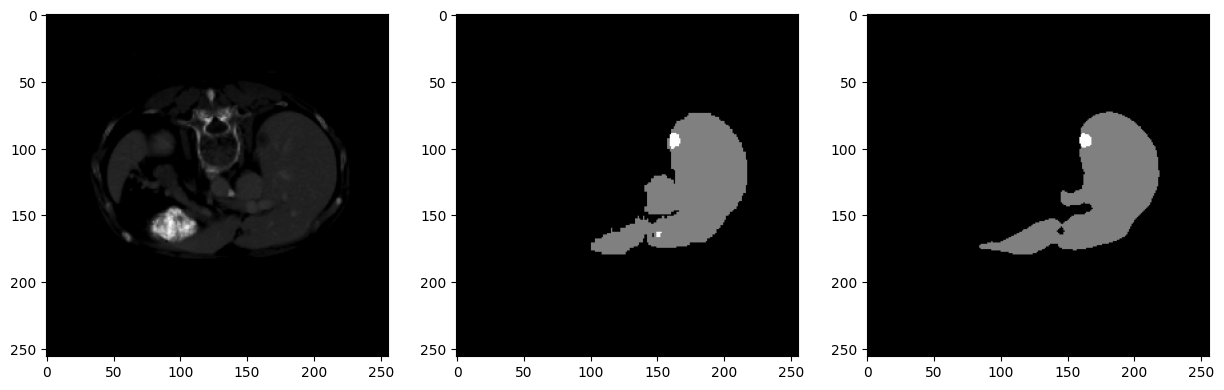

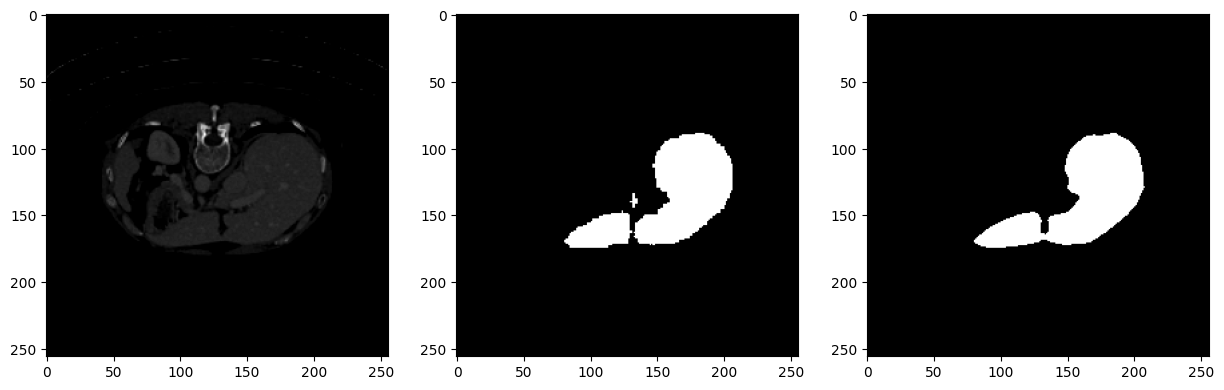

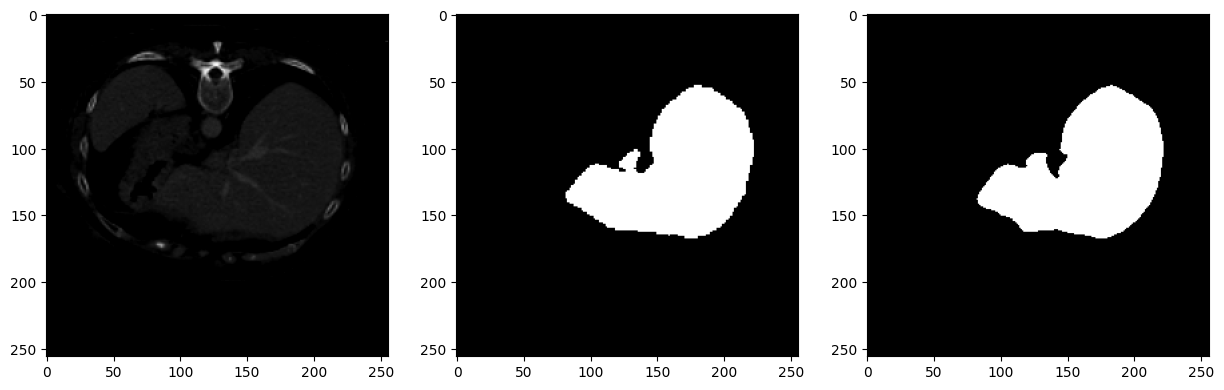

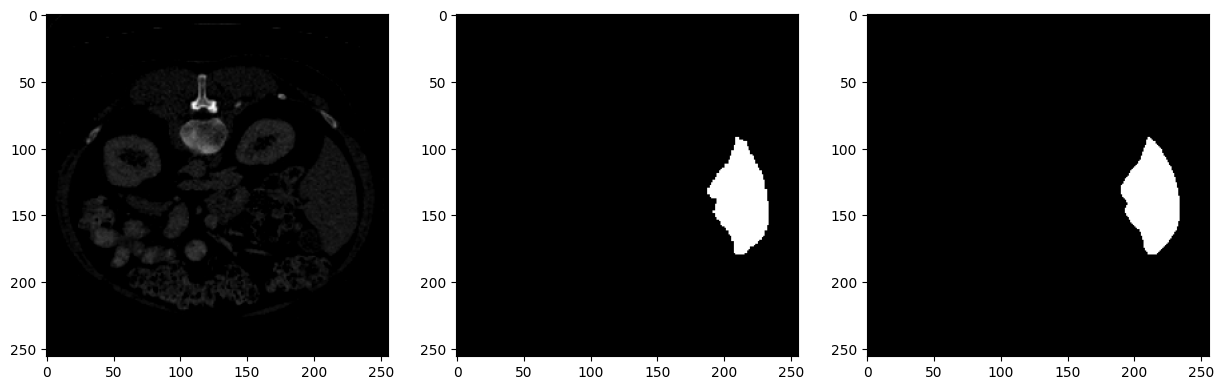

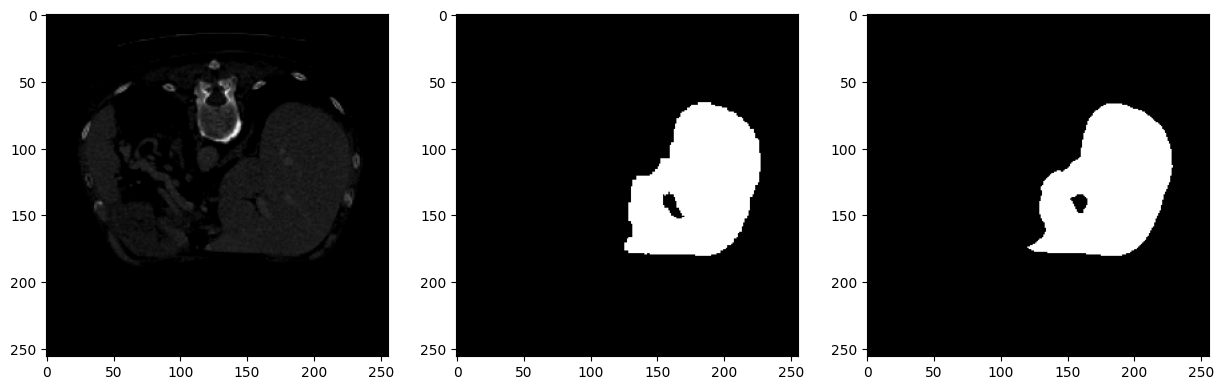

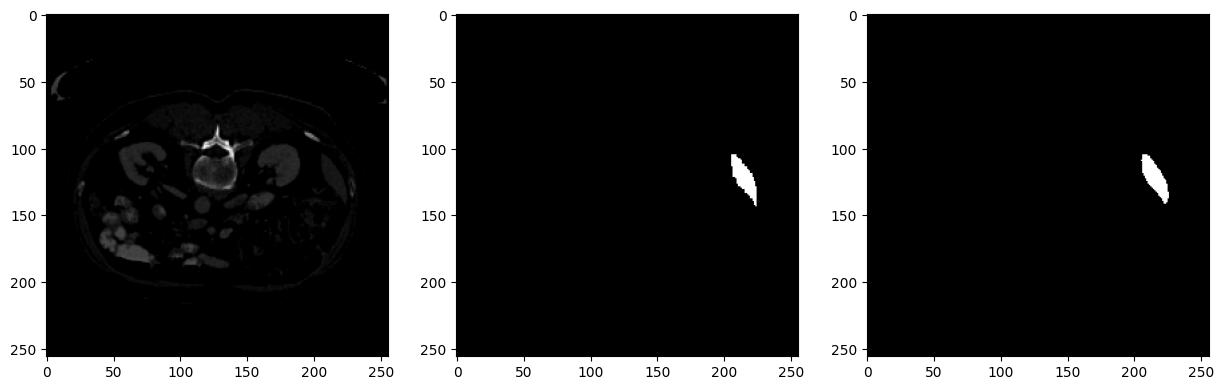

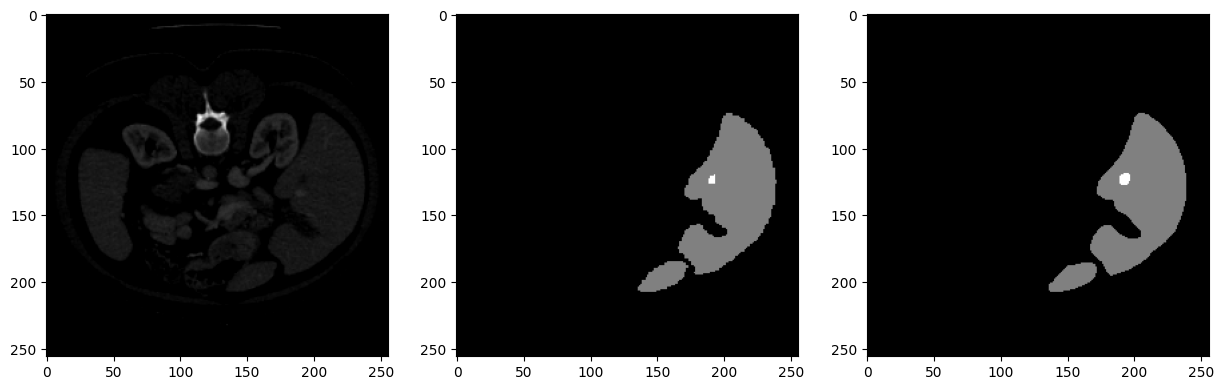

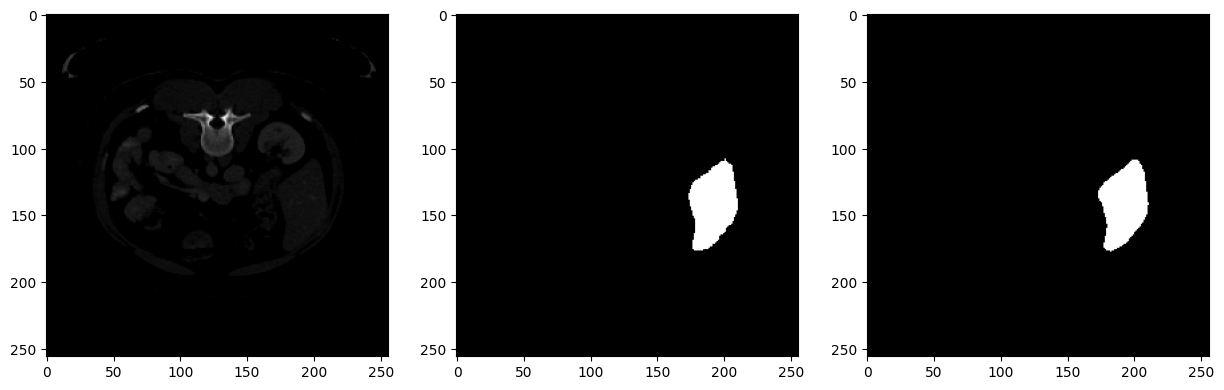

In [18]:
ans_show(model_DeepLabV3Plus, next(iter(val_dl)), convert_pred=get_DeepLabV3Plus_pred)

<h1>UNet модель</h1>

In [19]:
class CNA(nn.Module):
    def __init__(self, in_nc, out_nc, stride=1):
        super().__init__()
        
        self.conv = nn.Conv2d(in_nc, out_nc, 3, stride=stride, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_nc)
        self.act = nn.GELU()
    
    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        out = self.act(out)
        
        return out

    
class UnetBlock(nn.Module):
    def __init__(self, in_nc, inner_nc, out_nc, inner_block=None):
        super().__init__()
        
        self.conv1 = CNA(in_nc, inner_nc, stride=2)
        self.conv2 = CNA(inner_nc, inner_nc)
        self.inner_block = inner_block
        self.conv3 = CNA(inner_nc, inner_nc)
        self.conv_cat = nn.Conv2d(inner_nc+in_nc, out_nc, 3, padding=1)
        
    def forward(self, x):
        _,_,h,w = x.shape
        
        inner = self.conv1(x)
        inner = self.conv2(inner)
        #print(inner.shape)
        if self.inner_block is not None:
            inner = self.inner_block(inner)
        inner = self.conv3(inner)
        
        inner = F.interpolate(inner, size=(h,w), mode='bilinear')
        inner = torch.cat((x, inner), axis=1)
        out = self.conv_cat(inner)
        
        return out


class UNET(nn.Module):
    def __init__(self, in_nc=1, nc=32, out_nc=1, num_downs=6):
        super().__init__()
        
        self.cna1 = CNA(in_nc, nc)
        self.cna2 = CNA(nc, nc)
        
        unet_block = None
        for i in range(num_downs-3):
            unet_block = UnetBlock(8*nc, 8*nc, 8*nc, unet_block)
        unet_block = UnetBlock(4*nc, 8*nc, 4*nc, unet_block)
        unet_block = UnetBlock(2*nc, 4*nc, 2*nc, unet_block)
        self.unet_block = UnetBlock(nc, 2*nc, nc, unet_block)
        
        self.cna3 = CNA(nc, nc)
        
        self.conv_last = nn.Conv2d(nc, out_nc, 3, padding=1)

    def forward(self, x):
        out = self.cna1(x)
        out = self.cna2(out)
        out = self.unet_block(out)
        out = self.cna3(out)
        out = self.conv_last(out)
        
        return out

In [20]:
unet_model = UNET(in_nc=1, nc=32, out_nc=3, num_downs=5)
loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train(unet_model, loss_fn, scheduler, optimizer, device, 50, "unet")

Start training process...
Epoch 1 train process is started...


100%|██████████| 152/152 [00:55<00:00,  2.75it/s]


Epoch: 1	 loss: 0.5515527219364518	 lr: [0.0009000000000000001]
Epoch 2 train process is started...


100%|██████████| 152/152 [00:53<00:00,  2.82it/s]


Epoch: 2	 loss: 0.40086698630138445	 lr: [0.0008100000000000001]
Epoch 3 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 3	 loss: 0.364632765517423	 lr: [0.000729]
Epoch 4 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.80it/s]


Epoch: 4	 loss: 0.3504030645677918	 lr: [0.0006561000000000001]
Epoch 5 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 5	 loss: 0.3401889377518704	 lr: [0.00059049]
Epoch 6 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 6	 loss: 0.33492513344083963	 lr: [0.000531441]
Epoch 7 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 7	 loss: 0.32389303590906293	 lr: [0.0004782969]
Epoch 8 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 8	 loss: 0.31682898476719856	 lr: [0.00043046721]
Epoch 9 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 9	 loss: 0.31030476112899025	 lr: [0.000387420489]
Epoch 10 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.80it/s]


Epoch: 10	 loss: 0.30464721078935425	 lr: [0.0003486784401]
Epoch 11 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 11	 loss: 0.2988506135971923	 lr: [0.00031381059609000004]
Epoch 12 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 12	 loss: 0.29597980891795533	 lr: [0.00028242953648100003]
Epoch 13 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.80it/s]


Epoch: 13	 loss: 0.29324262540199253	 lr: [0.00025418658283290005]
Epoch 14 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.80it/s]


Epoch: 14	 loss: 0.29077762894724546	 lr: [0.00022876792454961005]
Epoch 15 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.80it/s]


Epoch: 15	 loss: 0.28917740354020344	 lr: [0.00020589113209464906]
Epoch 16 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 16	 loss: 0.2863440174413355	 lr: [0.00018530201888518417]
Epoch 17 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 17	 loss: 0.28503371412424666	 lr: [0.00016677181699666576]
Epoch 18 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 18	 loss: 0.2827777703733821	 lr: [0.0001500946352969992]
Epoch 19 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 19	 loss: 0.28229525028482866	 lr: [0.0001350851717672993]
Epoch 20 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.80it/s]


Epoch: 20	 loss: 0.2811648548629723	 lr: [0.00012157665459056936]
Epoch 21 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.80it/s]


Epoch: 21	 loss: 0.2801918605048406	 lr: [0.00010941898913151243]
Epoch 22 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 22	 loss: 0.27878469513042975	 lr: [9.847709021836118e-05]
Epoch 23 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 23	 loss: 0.27898262480371877	 lr: [8.862938119652506e-05]
Epoch 24 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 24	 loss: 0.27658059036261157	 lr: [7.976644307687256e-05]
Epoch 25 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 25	 loss: 0.2757192176619643	 lr: [7.17897987691853e-05]
Epoch 26 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 26	 loss: 0.27463427833036375	 lr: [6.461081889226677e-05]
Epoch 27 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 27	 loss: 0.27432122032501194	 lr: [5.81497370030401e-05]
Epoch 28 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 28	 loss: 0.27375128139790733	 lr: [5.233476330273609e-05]
Epoch 29 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 29	 loss: 0.27268208151585177	 lr: [4.7101286972462485e-05]
Epoch 30 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 30	 loss: 0.2727758710909831	 lr: [4.239115827521624e-05]
Epoch 31 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 31	 loss: 0.27183963456436205	 lr: [3.8152042447694614e-05]
Epoch 32 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 32	 loss: 0.27138955979362916	 lr: [3.433683820292515e-05]
Epoch 33 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 33	 loss: 0.2710781758160968	 lr: [3.090315438263264e-05]
Epoch 34 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 34	 loss: 0.271242995207247	 lr: [2.7812838944369376e-05]
Epoch 35 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 35	 loss: 0.270010462913074	 lr: [2.503155504993244e-05]
Epoch 36 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 36	 loss: 0.26989030318432733	 lr: [2.2528399544939195e-05]
Epoch 37 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 37	 loss: 0.27023168800300673	 lr: [2.0275559590445276e-05]
Epoch 38 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 38	 loss: 0.2683363516667956	 lr: [1.8248003631400748e-05]
Epoch 39 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 39	 loss: 0.269461691673649	 lr: [1.6423203268260675e-05]
Epoch 40 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.80it/s]


Epoch: 40	 loss: 0.26885834640186085	 lr: [1.4780882941434607e-05]
Epoch 41 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 41	 loss: 0.26882641899742576	 lr: [1.3302794647291146e-05]
Epoch 42 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 42	 loss: 0.26844235823342677	 lr: [1.1972515182562031e-05]
Epoch 43 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 43	 loss: 0.268237284139583	 lr: [1.0775263664305828e-05]
Epoch 44 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 44	 loss: 0.26809153068614633	 lr: [9.697737297875246e-06]
Epoch 45 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 45	 loss: 0.26758435319520923	 lr: [8.727963568087722e-06]
Epoch 46 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 46	 loss: 0.26746432385162305	 lr: [7.85516721127895e-06]
Epoch 47 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 47	 loss: 0.26731225112943274	 lr: [7.069650490151056e-06]
Epoch 48 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 48	 loss: 0.267688786512927	 lr: [6.362685441135951e-06]
Epoch 49 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]


Epoch: 49	 loss: 0.2671079546409218	 lr: [5.7264168970223554e-06]
Epoch 50 train process is started...


100%|██████████| 152/152 [00:54<00:00,  2.79it/s]

Epoch: 50	 loss: 0.2669923138853751	 lr: [5.15377520732012e-06]
Train process is completed in 45.455 minutes


In [21]:
@torch.inference_mode()
def get_unet_pred(model, img):
    model.eval()
    return torch.argmax(unet_model(img.to(device)), dim=1).cpu().squeeze(0)

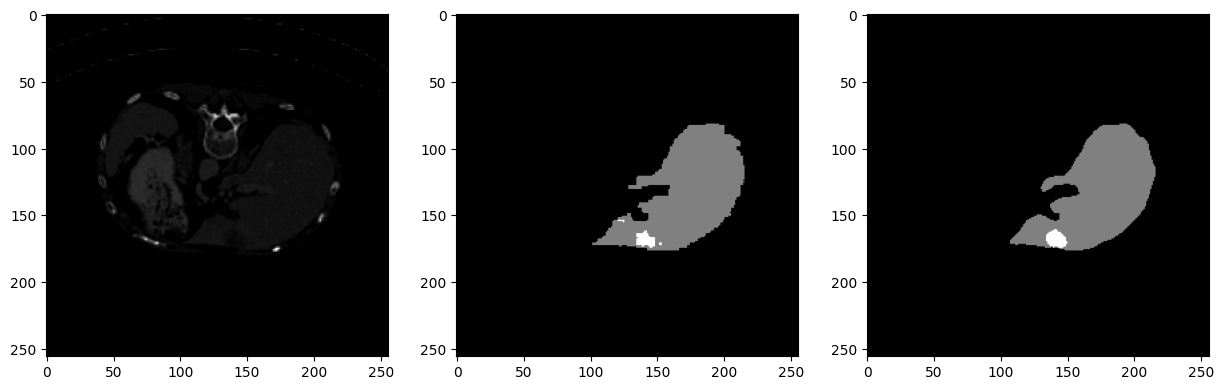

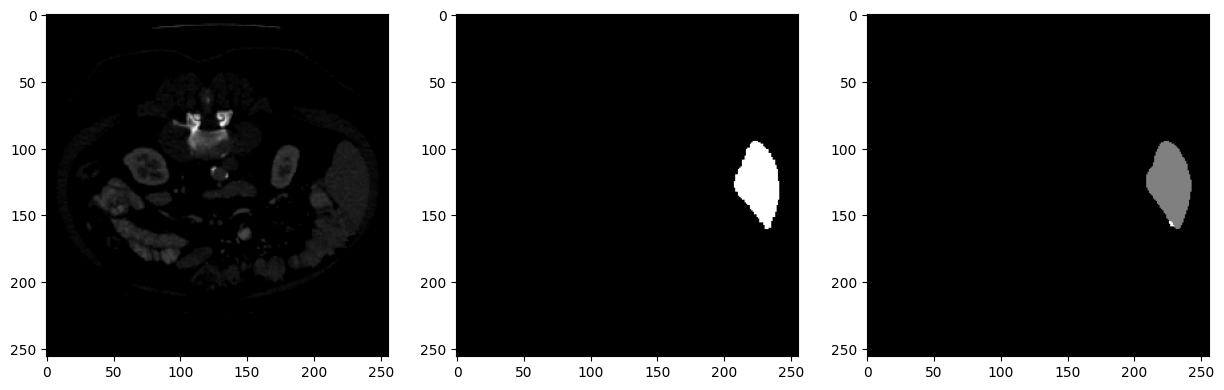

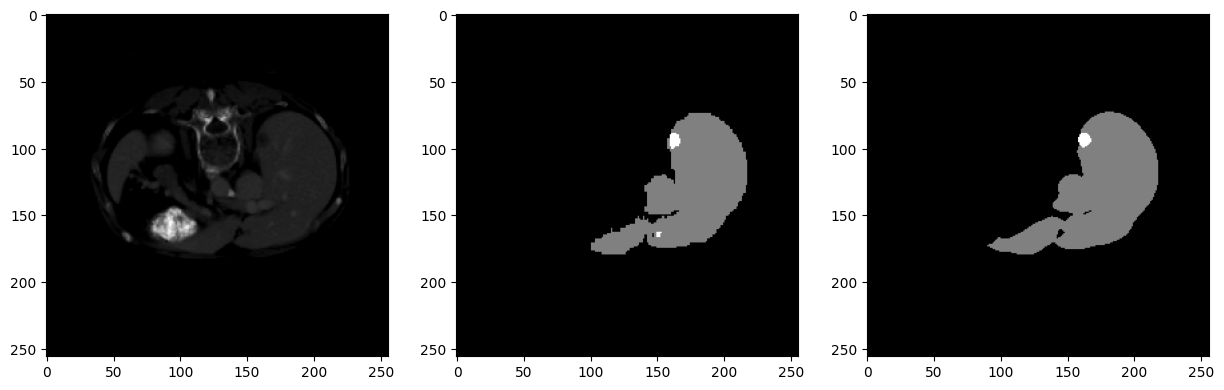

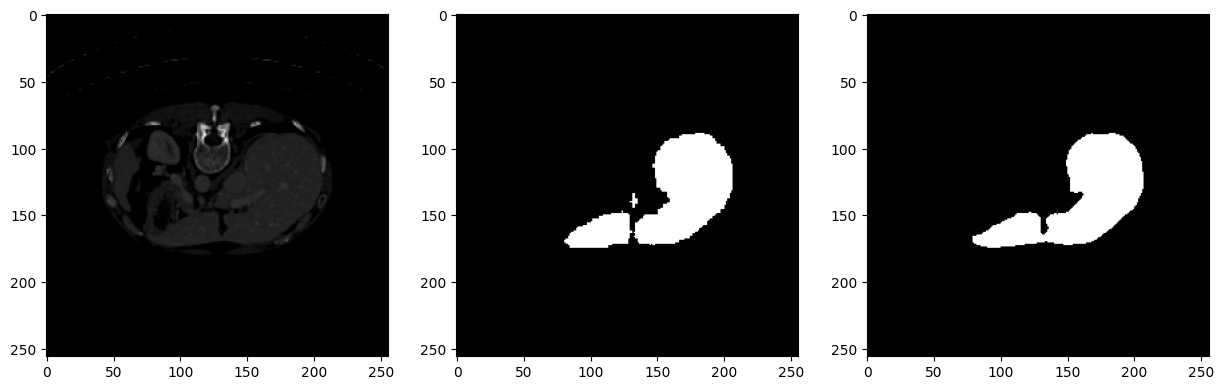

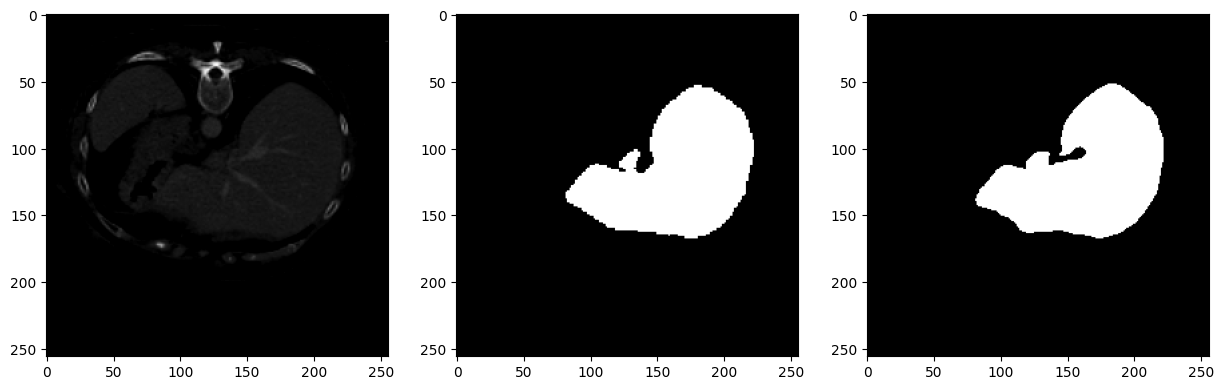

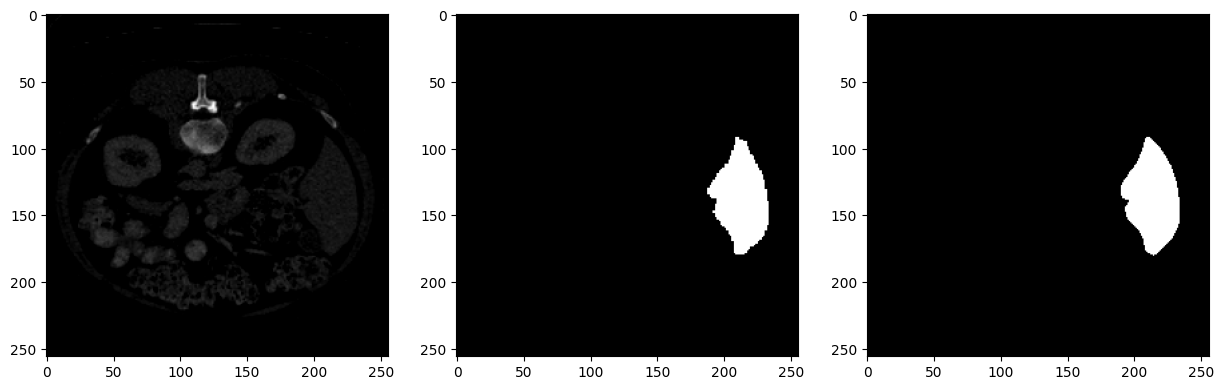

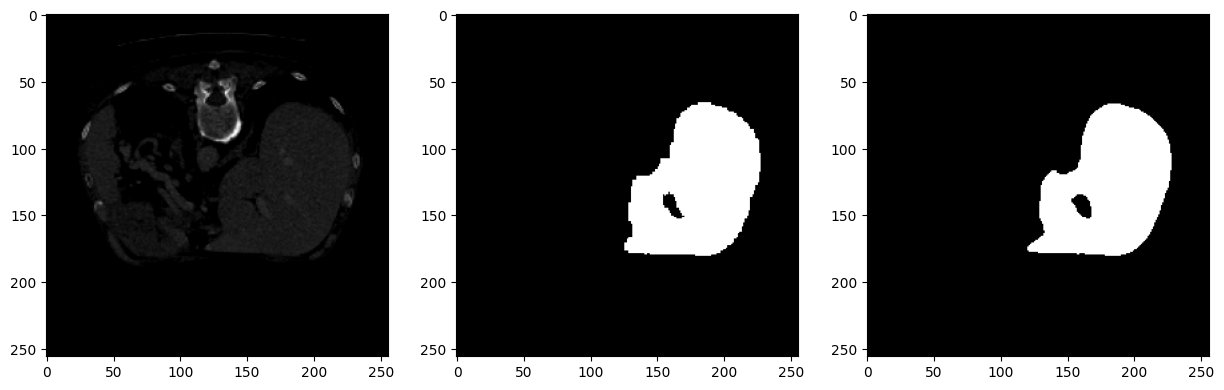

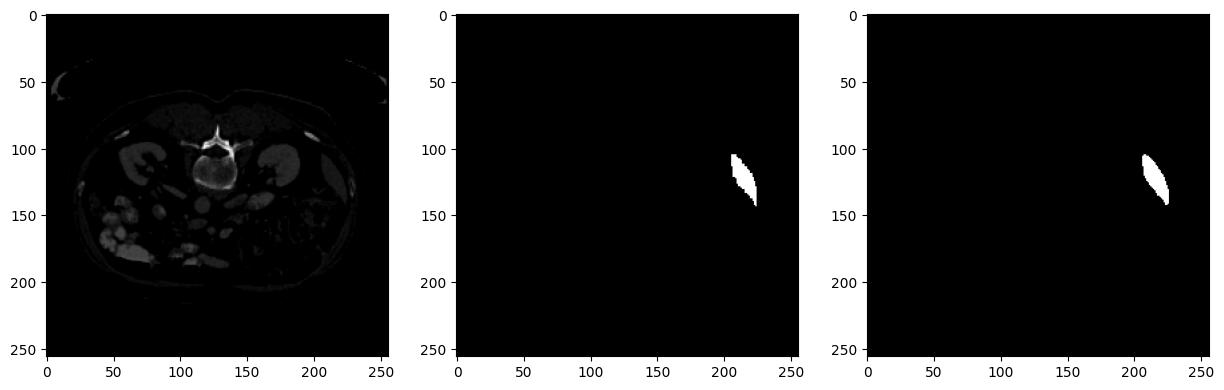

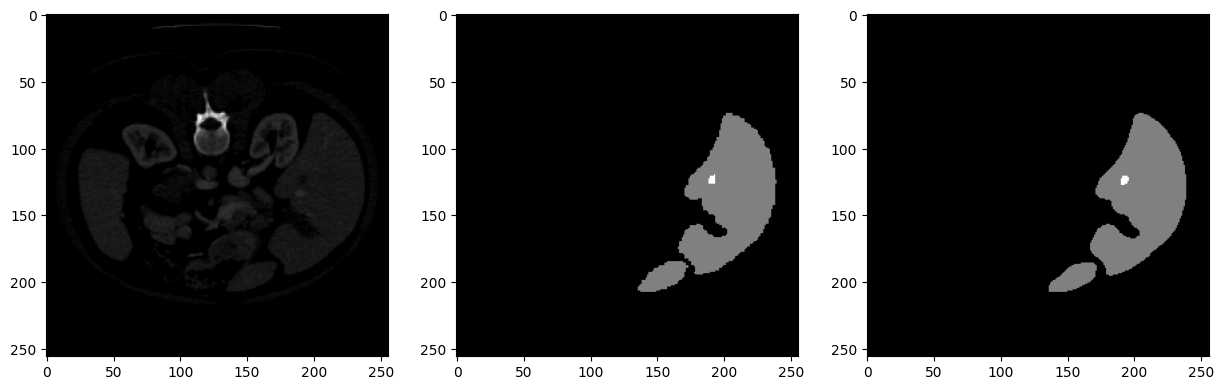

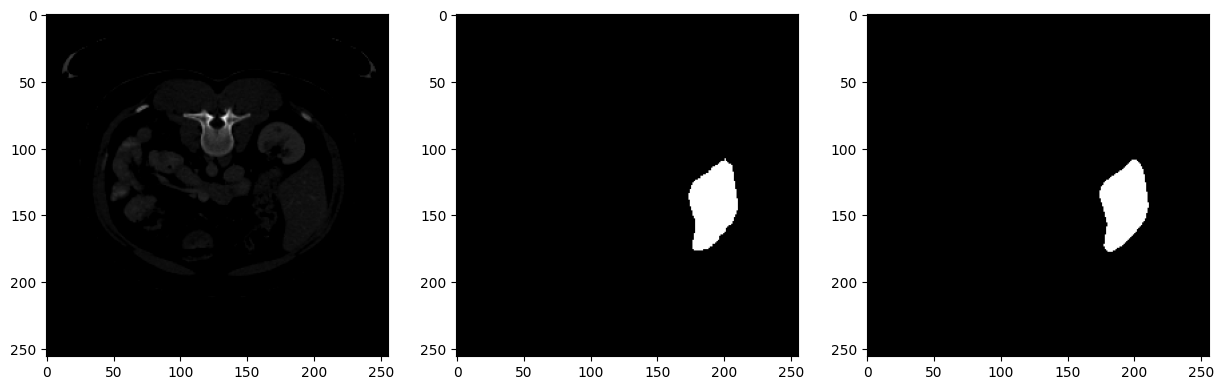

In [22]:
ans_show(unet_model, next(iter(val_dl)), convert_pred=get_unet_pred)

<h1>Результаты индекса Жакарда</h1>

In [23]:
print(f'UNet: {get_avg_jaccard(unet_model, val_dl)}')
print(f'DeepLab: {get_avg_jaccard(model_DeepLabV3Plus, val_dl)}')

UNet: 0.952795966675407
DeepLab: 0.9646156191041595


<h1>Результаты индекса Дайса</h1>

In [24]:
print(f'UNet: {get_avg_dice(unet_model, val_dl)}')
print(f'DeepLab: {get_avg_dice(model_DeepLabV3Plus, val_dl)}')

UNet: 0.9460300207138062
DeepLab: 0.9495160579681396
